In [17]:
#!/usr/bin/env python

import argparse
import os
import sys
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from scipy.io import savemat, loadmat
from scipy.integrate import solve_ivp


from torch.utils.data import DataLoader, TensorDataset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

import generalized_quad_embs.modules_quad_stable as module
import generalized_quad_embs.plots_helper as plot
import generalized_quad_embs.utils as utils
from generalized_quad_embs.constants import DATA_DIR
# from integrator import Mid_point


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("No GPU found!")
else:
    print("Great, a GPU is there")
print("=" * 50)

# Plotting setting
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

plt.rc("font", size=20)  # controls default text size
plt.rc("axes", titlesize=20)  # fontsize of the title
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=20)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=20)  # fontsize of the y tick labels
plt.rc("legend", fontsize=15)  # fontsize of the legend

No GPU found!


In [18]:
## Define the parameters
@dataclass
class Parameters:
    """It contain necessary parameters for this example."""

    canonical_dim = 3  # canonical dimension
    train_index = 600  # number of pts for training
    latent_dim = 6  # latent canonical dimensional
    hidden_dim = 16  # number of neurons in a hidden layer
    batch_size = 64  # batch size
    learning_rate = 5e-3  # Learning rate
    encoder = "MLP"
    confi_model: str = None  # model configuration
    epoch: int = None  # number of epochs which are externally controlled
    path: str = None # path where the results will be save and it is also externally controlled
    loss_weights: tuple = (10.0, 1.0)



In [19]:
def plot_singular_values():
    """It is a helper function for plotting singular values."""
    plt.rc("font", size=30)  # controls default text size

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.semilogy(_S / _S[0])
    ax.set(
        ylabel="singular values (rel)", xlabel="$k$", xlim=(-1, 50), ylim=(1e-6, 2e0)
    )
    ax.grid()
    plt.tight_layout()
    fig.savefig(params.path + "svd_plot.png", dpi=300)
    fig.savefig(params.path + "svd_plot.pdf")

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    Ssum = np.zeros_like(_S)
    Ssum[0] = _S[0]
    for i in range(len(_S[1:])):
        Ssum[i] = sum(_S[: i + 1])

    # plt.plot(_S)
    ax.plot(list(range(1, len(_S) + 1)), Ssum / sum(_S))
    ax.plot([3, 3], [0.05, 1.0], "g--")
    ax.plot([-1, 50], [sum(_S[:3]) / sum(_S), sum(_S[:3]) / sum(_S)], "g--")

    ax.set(ylabel="energy captured", xlabel="$k$", xlim=(-1, 20), ylim=(0.05, 1.05))
    ax.set_xticks([0, 3, 5, 10, 15, 20])
    ax.set_yticks([0.25, 0.527, 0.75, 1.0])
    ax.grid()
    plt.tight_layout()
    fig.savefig(params.path + "energy_plot.png", dpi=300)
    fig.savefig(params.path + "energy_plot.pdf")


def POD_coeffs_plots():
    """It is a helper function to plot POD coefficients
    (grouth truth as well as learned ones).
    """
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 3))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 3))

    for k in range(data.shape[-1]):
        ax1.plot(t, data[:, k].cpu())
        ax2.plot(t, decoded_latent_sol[:, k].cpu())
        ax1.set_ylim(-4.5, 4.5)
        ax2.set_ylim(-4.5, 4.5)

    ax1.set(xlabel="time", ylabel="POD coeffs")
    ax2.set(xlabel="time", ylabel="POD coeffs")

    fig1.savefig(
        params.path + f"pod_coeffs_ground_truth_{k}.png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.1,
    )
    fig1.savefig(
        params.path + f"pod_coeffs_ground_truth_{k}.pdf",
        bbox_inches="tight",
        pad_inches=0.1,
    )

    fig2.savefig(
        params.path + f"pod_coeffs_learned_{k}.png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.1,
    )
    fig2.savefig(
        params.path + f"pod_coeffs_learned_{k}.pdf", bbox_inches="tight", pad_inches=0.1
    )


def plot_decoded_solution(save_plots=True):
    """It is a helper function to plot solutions on the full grid.

    Args:
        save_plots (bool, optional): It indicates whether to save plots or not. Defaults to True.
    """

    def mycolorbar(ax):
        fbar = fig.colorbar(
            im,
            ax=ax,
            orientation="horizontal",
            pad=0.3,
            format="%.1e",
            ticks=[
                _min,
                (2 / 3) * _min + (1 / 3) * _max,
                (1 / 3) * _min + (2 / 3) * _max,
                _max,
            ],
        )
        tick_font_size = 13
        fbar.ax.tick_params(labelsize=tick_font_size)

    fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharex=True, sharey=True)

    _min, _max = np.min(q_data.T[:, ::1].numpy()), np.max(q_data.T[:, ::1].numpy())
    im = axes[0].pcolormesh(
        T[:, ::1], X[:, ::1], q_data.T[:, ::1], vmin=_min, vmax=_max
    )

    axes[0].set(title="ground truth", xlabel="time", ylabel="$q$")
    mycolorbar(axes[0])

    _min, _max = np.min(q_pod.T[:, ::1].numpy()), np.max(q_pod.T[:, ::1].numpy())
    im = axes[1].pcolormesh(T[:, ::1], X[:, ::1], q_pod.T[:, ::1], vmin=_min, vmax=_max)

    axes[1].set(title=" linear-decoder", xlabel="time")
    mycolorbar(axes[1])

    _min, _max = np.min(q_rec_quad.T[:, ::1].numpy()), np.max(
        q_rec_quad.T[:, ::1].numpy()
    )
    im = axes[2].pcolormesh(
        T[:, ::1], X[:, ::1], q_rec_quad.T[:, ::1], vmin=_min, vmax=_max
    )

    axes[2].set(title=" quad-decoder", xlabel="time")
    mycolorbar(axes[2])

    _min, _max = np.min(q_rec.T[:, ::1].numpy()), np.max(q_rec.T[:, ::1].numpy())
    im = axes[3].pcolormesh(T[:, ::1], X[:, ::1], q_rec.T[:, ::1], vmin=_min, vmax=_max)

    mycolorbar(axes[3])
    axes[3].set(title=" convo-decoder", xlabel="time")
    plt.subplots_adjust(wspace=0.3, hspace=0)

    if save_plots:
        plt.savefig(
            params.path + f"q_compare_{i}.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0.1,
        )
        # plt.savefig(
        #     params.path + f"q_compare_{i}.pdf", bbox_inches="tight", pad_inches=0.1
        # )

    fig, axes = plt.subplots(1, 4, figsize=(18, 3), sharex=True, sharey=True)

    _min, _max = np.min(p_data.T[:, ::1].numpy()), np.max(p_data.T[:, ::1].numpy())
    im = axes[0].pcolormesh(
        T[:, ::1], X[:, ::1], p_data.T[:, ::1], vmin=_min, vmax=_max
    )

    axes[0].set(title="ground truth", xlabel="time", ylabel="$p$")
    mycolorbar(axes[0])

    _min, _max = np.min(p_pod.T[:, ::1].numpy()), np.max(p_pod.T[:, ::1].numpy())
    im = axes[1].pcolormesh(T[:, ::1], X[:, ::1], p_pod.T[:, ::1], vmin=_min, vmax=_max)

    axes[1].set(title=" linear-decoder", xlabel="time")
    mycolorbar(axes[1])

    _min, _max = np.min(p_rec_quad.T[:, ::1].numpy()), np.max(
        p_rec_quad.T[:, ::1].numpy()
    )
    im = axes[2].pcolormesh(
        T[:, ::1], X[:, ::1], p_rec_quad.T[:, ::1], vmin=_min, vmax=_max
    )

    axes[2].set(title=" quad-decoder", xlabel="time")
    mycolorbar(axes[2])

    _min, _max = np.min(p_rec.T[:, ::1].numpy()), np.max(p_rec.T[:, ::1].numpy())
    im = axes[3].pcolormesh(T[:, ::1], X[:, ::1], p_rec.T[:, ::1], vmin=_min, vmax=_max)

    mycolorbar(axes[3])
    axes[3].set(title=" convo-decoder", xlabel="time")
    plt.subplots_adjust(wspace=0.3, hspace=0)

    if save_plots:
        plt.savefig(
            params.path + f"p_compare_{i}.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0.1,
        )
        # plt.savefig(
        #     params.path + f"p_compare_{i}.pdf", bbox_inches="tight", pad_inches=0.1
        # )


In [20]:
utils.reproducibility_seed(seed=100)

params = Parameters()
parser = argparse.ArgumentParser()

parser.add_argument(
    "--confi_model",
    type=str,
    default="quad_opinf",
    choices={"linear", "quad", "cubic", "linear_nostability", "quad_opinf"},
    help="Enforcing model hypothesis",
)

parser.add_argument("--epochs", type=int, default=400, help="Number of epochs")

args = parser.parse_args([])

params.confi_model = args.confi_model
params.epoch = args.epochs

params.path = "./../Results/Burgers/" + params.confi_model + "/"

if not os.path.exists(params.path):
    os.makedirs(params.path)
    print("The new directory is created as " + params.path)

color_idx, method_name = utils.define_color_method(params)

In [21]:
# ## Loading data
# data = loadmat("./Burgers_dirichilet_data.mat")
data = loadmat(str(DATA_DIR / "Burgers_dirichilet_data.mat"))


X_all = data["X_data"].transpose(0, 2, 1)[:,::1,:]
dX_all = data["dX_data"].transpose(0, 2, 1)[:,::1,:]

print(X_all.shape)
x_shift = 0 * np.ones((1, X_all.shape[1], 1))
X_all = X_all - x_shift

idxs = list(np.arange(0, 13))
testing_idxs = list([2, 5, 8, 11])
train_idxs = list(set(idxs) - set(testing_idxs))
# train_idxs = testing_idxs

# testing_idxs = list([2, 5, 8, 11])
# train_idxs = testing_idxs

X_testing = X_all[testing_idxs]
X_training = X_all[train_idxs]

dX_testing = dX_all[testing_idxs]
dX_training = dX_all[train_idxs]


t = data["t"].T
print(f"Training trajectories: {X_training.shape}")
print(f"Testing trajectories:  {X_testing.shape}\n")

num_inits = X_training.shape[0]
print(f"shape of X for training:\t{X_training.shape}")
print(f"Training samples: {num_inits}")

(13, 256, 1001)
Training trajectories: (9, 256, 1001)
Testing trajectories:  (4, 256, 1001)

shape of X for training:	(9, 256, 1001)
Training samples: 9


Error in callback <function _draw_all_if_interactive at 0x110b917e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

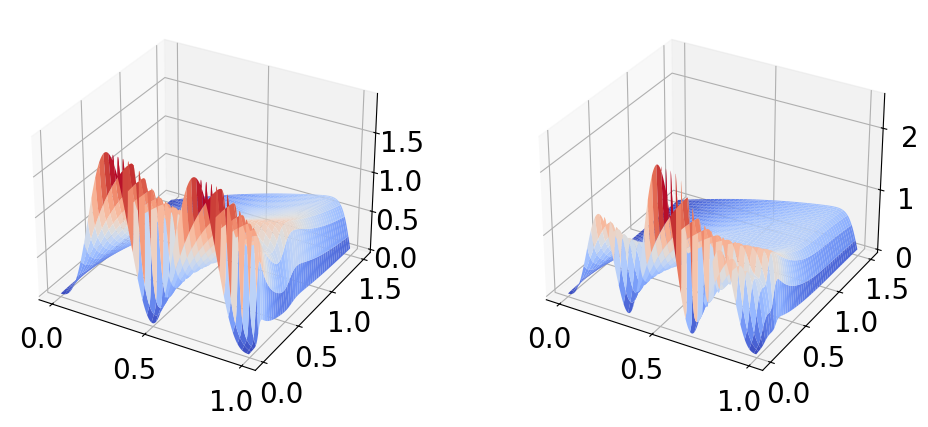

In [22]:
# Make grid.
x = np.arange(0, 1, 1 / 256)
y = np.array(t)
x, y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={"projection": "3d"})
# Plot the surface.
surf1 = ax[0].plot_surface(x, y, X_training[0][:1000].T, cmap=cm.coolwarm)
surf2 = ax[1].plot_surface(x, y, X_training[-1][:1000].T, cmap=cm.coolwarm)

In [ ]:
# Compute SVD in order to prepare low-dimensional data

temp_X = np.hstack(X_training)
[U, S, V] = np.linalg.svd(temp_X)

temp_dX = np.hstack(dX_training)

tol = 2.5e-1
reduced_orders = []

[U, S, V] = np.linalg.svd(temp_X)
r = 1
while r < len(S) + 1:
    if 1 - sum(S[:r]) / sum(S) < tol:
        break
    r += 1
    
print(f"Domainant model for first: {r}")
print(f"Energy captured by the snapshots: {100*sum(S[:r])/sum(S)}%")

Domainant model for first: 4
Energy captured by the snapshots: 76.59236853988288%


In [ ]:
params.canonical_dim = 4
params.latent_dim = 4

# print(f'Energy captured by the snapshots: {100*sum(S[:r])/sum(S)}%')
# preparing reduced data, approximating derivative information, and dataloader for training
Projection_V = U[:, :r]
# Projection_V = np.eye(256,256)
r = 4
print(f"Proj matrix shape: {Projection_V.shape}")
temp_Xr = Projection_V.T @ temp_X  # reduced data
temp_dXr = Projection_V.T @ temp_dX  # reduced data


fac = abs(temp_Xr).max()
# fac = 1
temp_Xr = temp_Xr/fac
temp_dXr = temp_dXr/fac


Xr = np.zeros((num_inits, r, temp_Xr.shape[-1] // num_inits))
dXr = np.zeros((num_inits, r, temp_Xr.shape[-1] // num_inits))

for i in range(0, num_inits):
    temp = int(temp_Xr.shape[-1] // num_inits)
    temp_x = temp_Xr[:, i * temp : (i + 1) * temp]
    temp_dx = temp_dXr[:, i * temp : (i + 1) * temp]
    Xr[i] = temp_x
    dXr[i] = temp_dx

Proj matrix shape: (256, 4)


In [ ]:
# to remove edge points since derivatives are not accutate therein.
Xr = Xr[:,:,:]
dXr = dXr[:,:,:]
print(Xr.shape)
print(dXr.shape)

Xr_v = np.hstack(Xr).T
dXr_v = np.hstack(dXr).T

train_dset = list(zip(torch.tensor(Xr_v).double().to(device).requires_grad_(), torch.tensor(dXr_v).double().to(device)))

train_dl = torch.utils.data.DataLoader(train_dset, batch_size = params.batch_size, shuffle = True)
dataloaders = {'train': train_dl}

(9, 4, 1001)
(9, 4, 1001)


In [ ]:
models = module.network_models(params)
# models['ae'] = AutoencoderConvo(latent_dim=4).double().to(device)
optim = torch.optim.Adam(
    [
        {
            "params": models["ae"].parameters(),
            "lr": params.learning_rate,
            "weight_decay": 1e-5,
        },
        {
            "params": models["vf"].parameters(),
            "lr": params.learning_rate,
            "weight_decay": 1e-5,
        },
    ]
)

Linear autoencoder and quad system with NO-gaurantee stability!
No Stability Gurantees!
B_term: True


In [ ]:
models, err_t = module.train_quad_conv(models, train_dl, optim, params)

function from train_quad_conv
Training begins!
weights for loss function are: (10.0, 1.0)
Epoch 1/400 | loss_VF: 1.28e+00 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 2/400 | loss_VF: 8.26e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 3/400 | loss_VF: 3.72e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 4/400 | loss_VF: 5.68e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 5/400 | loss_VF: 2.52e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 6/400 | loss_VF: 1.56e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 7/400 | loss_VF: 1.56e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 8/400 | loss_VF: 4.15e-02 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 9/400 | loss_VF: 1.71e-01 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 10/400 | loss_VF: 2.68e-02 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 11/400 | loss_VF: 8.97e-02 | loss_AE: 0.00e+00 | learning rate: 5.00e-03
Epoch 12/400 | loss_VF: 3.43e-02 | loss_AE: 0.00e+

KeyboardInterrupt: 

In [ ]:
train_dset_decoder = list(zip(torch.tensor(temp_X).double().to(device).T, torch.tensor(temp_Xr).double().to(device).T))

train_dl_decoder = torch.utils.data.DataLoader(train_dset_decoder, batch_size = params.batch_size, shuffle = True)
dataloaders_decoder = {'train': train_dl_decoder}
import torch.nn as nn
class QuadDecoder(nn.Module):
    def __init__(self, latent_dim, V, fac):
        super().__init__()

        # Encoder
        self.V = V
        self.n = V.shape[0]
        self.fac = fac
        self.latent_dim = latent_dim
        self.linear = nn.Linear(latent_dim**2, self.n, bias = False)
        self.linear.weight.data.fill_(0.0)

        
    def forward(self, z):
        z = self.fac*z
        z2 = utils.kron(z, z) 
        x_rec = z@self.V.T + self.linear(z2)
        return x_rec
    
def train_decoder(decoder, train_dl):
    
    optim = torch.optim.Adam(decoder.parameters(), lr = 3e-3, weight_decay=1e-4)
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optim, step_size=150 * len(train_dl), gamma=0.1
    )

    print("Training begins!")

    mse_loss = nn.MSELoss()

    err_t = []
    for i in range(400):
        for x, z in train_dl:
            x_rec = decoder(z)
            loss = mse_loss(x_rec,  x)
            with torch.no_grad():
                x_pod = decoder.fac*z@decoder.V.T
                loss_pod = mse_loss(x_pod, x)
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
            err_t.append(loss.item())

        if (i + 1) % 10 == 0:
            lr = optim.param_groups[0]["lr"]
            print(
                f"Epoch {i+1}/{400} | loss_AE: {loss.item():.2e} | loss_pod: {loss_pod.item():.2e} | learning rate: {lr:.2e}"
            )
    return decoder, err_t
            

model_decoder =  QuadDecoder(r, torch.from_numpy(Projection_V).double().to(device), 
                             torch.tensor(fac).double().to(device)).double().to(device)
model_decoder, err_decoder = train_decoder(model_decoder, train_dl_decoder)

In [ ]:
PROPERTY = {
    "cmap": cm.viridis,
    "antialiased": True,
    "rcount": 500,
    "ccount": 500,
    "linewidth": 0,
}

def plotting_chafee():
    fig, ax = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={"projection": "3d"})
    # Plot the surface.
    surf = ax[0].plot_surface(
        space_grid,
        time_grid,
        (X_testing[k] + x_shift.reshape(-1, 1)).T,
        **PROPERTY,
    )
    surf = ax[1].plot_surface(
        space_grid,
        time_grid,
        (full_sol_OpInf + x_shift.reshape(-1, 1)).T,
        **PROPERTY,
    )
    surf = ax[2].plot_surface(
        space_grid,
        time_grid,
        np.log10(abs((X_testing[k] - full_sol_OpInf).T)),
        **PROPERTY,
    )
    ax[0].set(xlabel="$x$", ylabel="time", zlabel="$u(x,t)$", title="groundtruth")

    ax[1].set(
        xlabel="$x$",
        ylabel="time",
        zlabel="$\hat{u}(x,t)$",
        title="learned model",
    )
    ax[2].set(
        xlabel="$x$",
        ylabel="time",
        zlabel="error in log-scale",
        title="absolute error",
    )


    for _ax in ax:
        _ax.xaxis.labelpad = 10
        _ax.yaxis.labelpad = 20
        _ax.zaxis.labelpad = 10

    ax[2].tick_params(axis="z", direction="out", pad=10)
    ax[2].zaxis.labelpad = 20

    ax[2].set_zscale("linear")

    plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)

    # plt.show()
    # fig.savefig(
    #     params.path + f"simulation_test_{k}_order_{r}.pdf",
    #     bbox_inches="tight",
    #     pad_inches=0,
    # )

    return fig






In [ ]:
# Extracting autoencoder and hnn (hamiltonian)
autoencoder, vf = models["ae"], models["vf"]

In [ ]:
# Prepare learned models for integration
def learned_model(t, x):
    """It yields time-derivative of x at time t.
    It is obtained throught the time-derivative of Hamiltonian function.

    Args:
        t (float): time
        x (float): state variable containing position and momenta.

    Returns:
        float: time-derivative of x
    """
    x = torch.tensor(
        x.reshape(-1, params.latent_dim), dtype=torch.float64, requires_grad=True
    ).to(device)
    y = vf.vector_field(x)
    y = y.detach()
    return y.cpu().numpy()

In [ ]:
def plot_decoded_solution(gt, learned, title = 'learned', save_plots=True):
    """It is a helper function to plot solutions on the full grid.

    Args:
        save_plots (bool, optional): It indicates whether to save plots or not. Defaults to True.
    """

    def mycolorbar(ax):
        fbar = fig.colorbar(
            im,
            ax=ax,
            orientation="horizontal",
            pad=0.3,
            format="%.1e",
            ticks=[
                _min,
                (2 / 3) * _min + (1 / 3) * _max,
                (1 / 3) * _min + (2 / 3) * _max,
                _max,
            ],
        )
        tick_font_size = 13
        fbar.ax.tick_params(labelsize=tick_font_size)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    _min, _max = np.min(gt), np.max(gt)
    im = axes[0].pcolormesh(
        space_grid, time_grid, gt, vmin=_min, vmax=_max
    )

    axes[0].set(title="ground truth", xlabel="space", ylabel="time")
    mycolorbar(axes[0])

    _min, _max = np.min(learned), np.max(learned)
    im = axes[1].pcolormesh(
        space_grid, time_grid, learned, vmin=_min, vmax=_max
    )

    axes[1].set(title=title, xlabel="space", ylabel="time")
    mycolorbar(axes[1])
    
    plt.tight_layout(pad=0.5, w_pad=1, h_pad=0.2)

    return fig




In [ ]:
models['vf'] = models['vf'].to(device)

t = np.arange(0, len(t)) * (t[1] - t[0])

# testing learned model
space = np.arange(0, 1, 1 / 256)
time = np.array(data["t"].T)
space_grid, time_grid = np.meshgrid(space, time)

Err_testing = []
Learned_sols = []
Truth_sols = []

with torch.no_grad():
    for k in range(X_testing.shape[0]):
        y0_test = Projection_V.T @ X_testing[k, :, 0]/fac
        encoded_initial = autoencoder.encode(torch.from_numpy(y0_test)[None].to(device)).reshape(-1,).detach().cpu()
        print(f'Initial condition encoded: {encoded_initial.shape}')

        sol_OpInf = solve_ivp(learned_model, [t[0], t[-1]], y0=encoded_initial, 
                              t_eval=t, rtol = 1e-8, atol = 1e-8)
        
        sol_OpInf = torch.tensor(sol_OpInf.y, dtype=torch.float64).to(device)
        decoded_latent_sol = autoencoder.decode(sol_OpInf.T).detach().cpu().numpy()
        print(f'decoded solution: {decoded_latent_sol.shape}')

        full_sol_OpInf = fac*Projection_V @ decoded_latent_sol.T

        fig = plot_decoded_solution((X_testing[k] + x_shift.reshape(-1, 1)).T, 
                                    (full_sol_OpInf + x_shift.reshape(-1, 1)).T,
                                   title = 'linearproj_quadOpInf')
        
        fig.savefig(
            params.path + f"simulation_test_{k}_order_{r}_linearproj_quadOpinf_2D.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0,
        )
        
        fig = plotting_chafee()
        
        fig.savefig(
            params.path + f"simulation_test_{k}_order_{r}_linearproj_quadOpinf_3D.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0,
        )
        
            
        err = (np.linalg.norm(full_sol_OpInf - X_testing[k])) / (
            np.linalg.norm(X_testing[k])
        )
        # print(abs(full_sol_OpInf - X_testing[k]))
        print(f'test {k} error: {err}')
        Err_testing.append(err)
        Truth_sols.append(X_testing[k])
        Learned_sols.append(full_sol_OpInf)
        
    savemat(params.path + f"simulation_error_order_{r}_linearproj_quadOpinf.mat", {"errors": Err_testing, 
                                                                                "learned_sols":Learned_sols,
                                                                                "truth_sols": Truth_sols
                                                                                })

In [ ]:
models['vf'] = models['vf'].to(device)

t = np.arange(0, len(t)) * (t[1] - t[0])

# testing learned model
space = np.arange(0, 1, 1 / 256)
time = np.array(data["t"].T)
space_grid, time_grid = np.meshgrid(space, time)

Err_testing = []
Learned_sols = []
Truth_sols = []
with torch.no_grad():
    for k in range(X_testing.shape[0]):
        y0_test = Projection_V.T @ X_testing[k, :, 0]/fac
        encoded_initial = autoencoder.encode(torch.from_numpy(y0_test)[None].to(device)).reshape(-1,).detach().cpu()
        print(f'Initial condition encoded: {encoded_initial.shape}')

        sol_OpInf = solve_ivp(learned_model, [t[0], t[-1]], y0=encoded_initial, 
                              t_eval=t, rtol = 1e-8, atol = 1e-8)
        
        sol_OpInf = torch.tensor(sol_OpInf.y, dtype=torch.float64).to(device)
        decoded_latent_sol = autoencoder.decode(sol_OpInf.T)
        print(f'decoded solution: {decoded_latent_sol.shape}')

        full_sol_OpInf = model_decoder(decoded_latent_sol).T.cpu().numpy()

        fig = plot_decoded_solution((X_testing[k] + x_shift.reshape(-1, 1)).T, 
                                    (full_sol_OpInf + x_shift.reshape(-1, 1)).T,
                                   title = 'quadproj_quadOpInf')
        
        fig.savefig(
            params.path + f"simulation_test_{k}_order_{r}_quadproj_quadOpinf_2D.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0,
        )
        
        fig = plotting_chafee()
        
        fig.savefig(
            params.path + f"simulation_test_{k}_order_{r}_quadproj_quadOpinf_3D.png",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0,
        )
        
        
        err = (np.linalg.norm(full_sol_OpInf - X_testing[k])) / (
            np.linalg.norm(X_testing[k])
        )
        # print(abs(full_sol_OpInf - X_testing[k]).max())
        print(f'test {k} error: {err}')
        Err_testing.append(err)
        Truth_sols.append(X_testing[k])
        Learned_sols.append(full_sol_OpInf)
    savemat(params.path + f"simulation_error_order_{r}_quadproj_quadOpinf.mat",  {"errors": Err_testing, 
                                                                                  "learned_sols":Learned_sols,
                                                                                  "truth_sols": Truth_sols
                                                                                 })